# COMP 551 Assignment 2

## Classification of Textual Data from IMDB Dataset

# Task 1: Data Preprocessing

### 1.1: Load the IMDB dataset into training and testing datasets and preprocess

Here, we setup a new function for the IMDB dataset that will allow us to download the dataset and organize the reviews by their index, the general sentiment (positive or negative), and the rating given.  Following this we organize the reviews into positive and negative groups within larger groups of training and testing data.  This reflects the way the data is organized from the download itself with 50% of the data in the train folder, and 50% of the data in the test folder.

In [ ]:
import os
import requests
import tarfile
from io import BytesIO

# Function to download and extract the IMDB dataset
def download_and_extract_imdb_dataset(url: str, download_dir: str):
    response = requests.get(url)
    if response.status_code == 200:
        # Extracting the tar.gz file
        with tarfile.open(fileobj=BytesIO(response.content), mode="r:gz") as tar:
            tar.extractall(download_dir)
        print("Dataset downloaded and extracted successfully.")
    else:
        print("Failed to download the dataset.")

# URL to download the dataset
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Directory to download the dataset
download_dir = "./"

# Download and extract the dataset
download_and_extract_imdb_dataset(url, download_dir)

# Now, you can proceed with your existing code to load the dataset
# Your existing code to load and process the dataset goes here...


Dataset downloaded and extracted successfully.


In [ ]:
from collections import Counter
import numpy as np

# Function to load IMDB reviews
def load_imdb_reviews(aclImdb_dir: str, sentiment: str) -> list:
    """Load reviews from the aclImdb folder"""
    instances = []
    for filename in os.listdir(os.path.join(aclImdb_dir, sentiment)):
        with open(os.path.join(aclImdb_dir, sentiment, filename), 'r') as file:
            review = file.read()
            instances.append((review, sentiment))
    return instances

# Function to extract features from reviews
def extract_features(reviews, filtered_words):
    features = []
    for review, _ in reviews:
        words = review.split()
        feature_vector = [1 if word in words else 0 for word in filtered_words]
        features.append(feature_vector)
    return features

# Load training instances
train_pos_reviews = load_imdb_reviews('./aclImdb/train', 'pos')
train_neg_reviews = load_imdb_reviews('./aclImdb/train', 'neg')

# Load test instances
test_pos_reviews = load_imdb_reviews('./aclImdb/test', 'pos')
test_neg_reviews = load_imdb_reviews('./aclImdb/test', 'neg')

# Count word occurrences in training data
word_counts = Counter()
for review, _ in train_pos_reviews + train_neg_reviews + test_pos_reviews + test_neg_reviews:
    words = review.split()
    word_counts.update(words)

# Filter out rare and stopwords
min_df = len(train_pos_reviews + train_neg_reviews + test_pos_reviews + test_neg_reviews) * 0.01
max_df = len(train_pos_reviews + train_neg_reviews + test_pos_reviews + test_neg_reviews) * 0.5
filtered_words = [word for word, count in word_counts.items() if min_df < count < max_df]

# Extract features from training data
X_train_pos = extract_features(train_pos_reviews, filtered_words)
X_train_neg = extract_features(train_neg_reviews, filtered_words)
X_train = np.array(X_train_pos + X_train_neg)
y_train = np.array([1] * len(train_pos_reviews) + [0] * len(train_neg_reviews))

# Extract features from test data
X_test_pos = extract_features(test_pos_reviews, filtered_words)
X_test_neg = extract_features(test_neg_reviews, filtered_words)
X_test = np.array(X_test_pos + X_test_neg)
y_test = np.array([1] * len(test_pos_reviews) + [0] * len(test_neg_reviews))



## Feature Extraction with Simple Linear Regression

Below we have our Linear Regression function designed to extract features with the greatest contribution to both positive and negative sentiment scores.  We fit the training data to the model, make predictions on the test set, and calculate the Mean Squared Error (MSE).  We then use the coefficient weights to determine the top 100 features for each class and use a sorting function to report the results.  The listed terms contributing to positive/negative sentiments largely make intuitive sense such as "great" and "excellent" for the positive sentiment, with terms like "waste" and "worst" weighing highly for negative sentiment.  

In [ ]:
import numpy as np
import pandas as pd

class LinearRegression:

    def __init__(self, learning_rate: float=1e-2, n_iters: int=2000) -> None:

        self.lr = learning_rate
        self.n_iters = n_iters
        self.w, self.bias =  None, None

    def fit(self, X: np.array, y: np.array) -> None:
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.bias = 0

        # gradient descent optimization
        for _ in range(self.n_iters):
            y_hat = np.dot(X, self.w) + self.bias
            dj_dw = (1/n_samples) * np.dot(X.T, (y_hat - y))
            dj_db = (1/n_samples) * (y_hat - y).sum()

            self.w = self.w - self.lr*dj_dw
            self.bias = self.bias - self.lr*dj_db

    def predict(self, X: np.array) -> np.array:
        return np.dot(X, self.w) + self.bias

    def weights(self) -> np.array:
        return self.w

In [ ]:
# Instantiate linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate MSE
mse = np.mean((y_pred - y_test)**2)
print("Mean Squared Error:", mse)

# Get important input features (coefficients)
coefficients = model.weights()

Mean Squared Error: 0.13266577363117874


## Top 10 +/- Features From Linear Regression
Here you can find a graph representing the top 10 positive features and top 10 negative features by their coefficient from the linear regression.

In [ ]:
import pandas as pd
import numpy as np

def sort_top_features_by_coefficients(feature_names, coefficients, D):
    # Calculate absolute coefficients
    abs_coefficients = np.abs(coefficients)

    # Get indices of top D features based on absolute coefficients
    sorted_indices = np.argsort(abs_coefficients)[::-1][:D]

    # Adjust indices to account for bias if it exists
    if len(feature_names) == len(coefficients) - 1:
        sorted_indices = [i - 1 for i in sorted_indices if i != len(coefficients) - 1]

    # Extract top D features and their corresponding coefficients
    top_features_with_coefficients = [(feature_names[i], coefficients[i]) for i in sorted_indices]

    # Separate positive and negative coefficients
    positive_features = [(feature, coef) for feature, coef in top_features_with_coefficients if coef > 0]
    negative_features = [(feature, coef) for feature, coef in top_features_with_coefficients if coef < 0]

    # Sort the top positive and negative features by coefficient values
    sorted_top_positive_features = sorted(positive_features, key=lambda x: np.abs(x[1]), reverse=True)
    sorted_top_negative_features = sorted(negative_features, key=lambda x: np.abs(x[1]), reverse=True)

    # Convert to DataFrame for better readability
    df_positive_features = pd.DataFrame(sorted_top_positive_features, columns=['Feature', 'Coefficient'])
    df_negative_features = pd.DataFrame(sorted_top_negative_features, columns=['Feature', 'Coefficient'])

    return df_positive_features, df_negative_features

# Choose D = 100
D = 100

# Call the function to sort the top D features by coefficients for positive and negative reviews
df_positive_features, df_negative_features = sort_top_features_by_coefficients(filtered_words, coefficients, D)

# Print the top positive features
print("Top 100 features contributing to a positive review:")
print(df_positive_features[:10])

# Print the top negative features
print("\nTop 100 features contributing to a negative review:")
print(df_negative_features[:10])


Top 100 features contributing to a positive review:
     Feature  Coefficient
0      great     0.104445
1  excellent     0.099427
2       best     0.093569
3    perfect     0.072433
4      loved     0.071704
5  wonderful     0.071465
6    enjoyed     0.069760
7   favorite     0.066854
8       well     0.064684
9       love     0.063270

Top 100 features contributing to a negative review:
    Feature  Coefficient
0     worst    -0.159869
1     waste    -0.115960
2       bad    -0.109012
3      poor    -0.079165
4   nothing    -0.076872
5     awful    -0.075401
6    boring    -0.073486
7  supposed    -0.069068
8    poorly    -0.066930
9      bad.    -0.061575


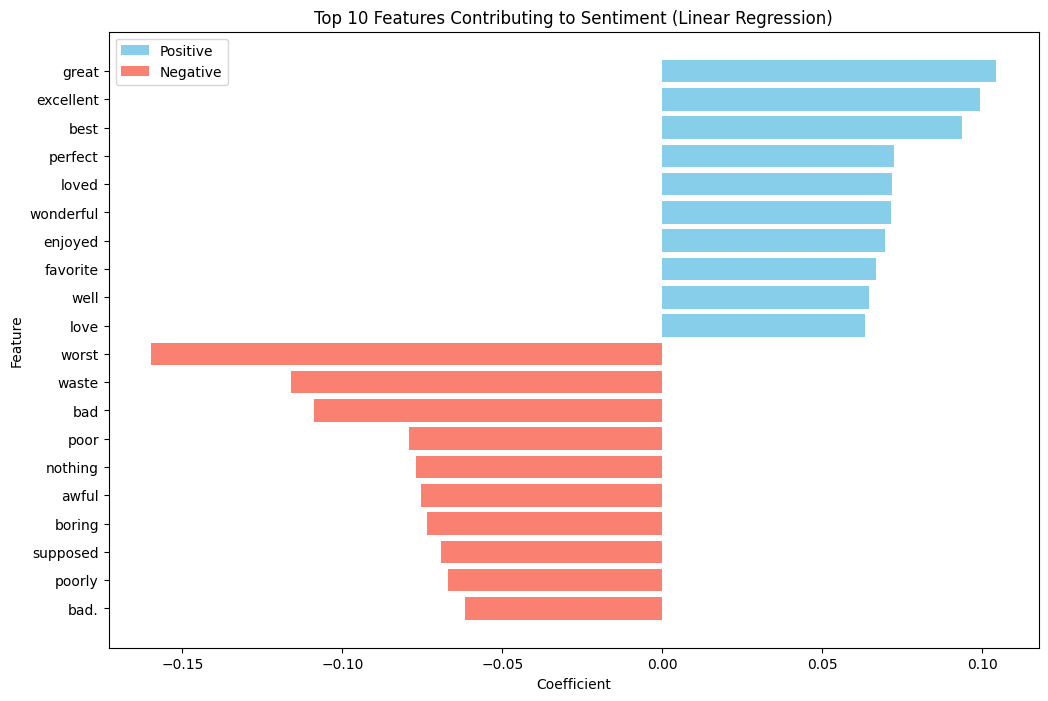

In [ ]:
import matplotlib.pyplot as plt

# Function to plot the top positive and negative features on the same plot
def plot_combined_top_features(df_positive, df_negative, title):
    plt.figure(figsize=(12, 8))

    # Plot positive features
    plt.barh(df_positive['Feature'], df_positive['Coefficient'], color='skyblue', label='Positive')

    # Plot negative features
    plt.barh(df_negative['Feature'], df_negative['Coefficient'], color='salmon', label='Negative')

    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.title(title)
    plt.legend()
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient on top
    plt.show()

# Plot the top positive and negative features on the same plot
plot_combined_top_features(df_positive_features[:10], df_negative_features[:10], "Top 10 Features Contributing to Sentiment (Linear Regression)")


# Task 2: Logistic Regression With Gradient Descent

Here we implement our defined Logistic Regression model with a sigmoid Logistic Function, Cross Entropy as our cost function, and a gradient descent function.  The implementation we conducted was limited to a maximum of 10,000 iterations (1e4 as opposed to the to the default 1e5) to offset long processing times, and defaults to a learning rate of 0.1.

In [ ]:
# Logistic function
logistic = lambda z: 1. / (1 + np.exp(-z))

# Cost function
def cost_fn(x, y, w):
    N, D = x.shape
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1 - y) * np.log1p(np.exp(z)))
    return J

class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = int(max_iters)  # Convert max_iters to integer
        self.verbose = verbose
        self.cost_history_train = []  # List to store the cost function value for training set
        self.cost_history_val = []  # List to store the cost function value for validation set
        self.w = None # Initialize weights to be set later
    def gradient(self, x, y):
        N, D = x.shape
        yh = logistic(np.dot(x, self.w))  # Predictions
        grad = np.dot(x.T, yh - y) / N    # Compute gradient
        return grad

    def fit(self, x_train, y_train, x_val=None, y_val=None):
        if x_train.ndim == 1:
            x_train = x_train[:, None]
        if self.add_bias:
            N_train = x_train.shape[0]
            x_train = np.column_stack([x_train, np.ones(N_train)])  # Add bias term
        N_train, D = x_train.shape

        if self.w is None:
          self.w = np.zeros(D)  # Initialize weights
        print('x_train shape after bias term:', x_train.shape)
        print('self.w shape:', self.w.shape)

        if x_val is not None:
            if x_val.ndim == 1:
                x_val = x_val[:, None]
            if self.add_bias:
                N_val = x_val.shape[0]
                x_val = np.column_stack([x_val, np.ones(N_val)])  # Add bias term to validation data

        self.w = np.zeros(D)  # Initialize weights
        g = np.inf
        t = 0
        # Gradient descent loop
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x_train, y_train)  # Compute gradient
            self.w = self.w - self.learning_rate * g  # Update weights
            cost_train = cost_fn(x_train, y_train, self.w)  # Calculate cost for training set
            self.cost_history_train.append(cost_train)  # Append cost to history for training set
            if x_val is not None and y_val is not None:
                cost_val = cost_fn(x_val, y_val, self.w)  # Calculate cost for validation set
                self.cost_history_val.append(cost_val)  # Append cost to history for validation set
            if self.verbose:
                print(f'Iteration {t}, Norm of Gradient: {np.linalg.norm(g)}, Cost (Train): {cost_train}')
                if x_val is not None and y_val is not None:
                    print(f'Iteration {t}, Cost (Validation): {cost_val}')
            t += 1

        if self.verbose:
            print(f'Terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'The weight found: {self.w}')
        return self

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x, np.ones(Nt)])  # Add bias term
        yh = logistic(np.dot(x, self.w))  # Predict output
        return yh


In [ ]:
from sklearn.model_selection import train_test_split

# Split X_train and y_train into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train_split shape:', X_train_split.shape)
print('X_val_split shape:', X_val_split.shape)

# Initialize logistic regression model
logistic_regression = LogisticRegression(add_bias=True, learning_rate=0.1, epsilon=1e-4, max_iters=10000, verbose=True)

# Fit the model on training data with validation data
logistic_regression.fit(X_train_split, y_train_split, X_val_split, y_val_split)

# Make predictions on test data
y_pred = logistic_regression.predict(X_test)


Streaming output truncated to the last 5000 lines.
Iteration 7501, Cost (Validation): 0.34700271244221415
Iteration 7502, Norm of Gradient: 0.0056776283142384995, Cost (Train): 0.28865495779051875
Iteration 7502, Cost (Validation): 0.34700332777844634
Iteration 7503, Norm of Gradient: 0.005677021654448901, Cost (Train): 0.2886517351052007
Iteration 7503, Cost (Validation): 0.34700394342779706
Iteration 7504, Norm of Gradient: 0.005676415121850418, Cost (Train): 0.28864851310845113
Iteration 7504, Cost (Validation): 0.3470045593901189
Iteration 7505, Norm of Gradient: 0.005675808716400019, Cost (Train): 0.28864529180005205
Iteration 7505, Cost (Validation): 0.3470051756652646
Iteration 7506, Norm of Gradient: 0.005675202438054689, Cost (Train): 0.2886420711797859
Iteration 7506, Cost (Validation): 0.3470057922530868
Iteration 7507, Norm of Gradient: 0.005674596286771427, Cost (Train): 0.2886388512474348
Iteration 7507, Cost (Validation): 0.3470064091534383
Iteration 7508, Norm of Gradie

## Convergence of Logistic Regression

Here we see a plot showing the cost minimization by gradient descent for our training and validation sets.  After roughly 6000 iterations it is clear that some slight overfitting of the model ocurs as the error for the vaildation set begins to increase.

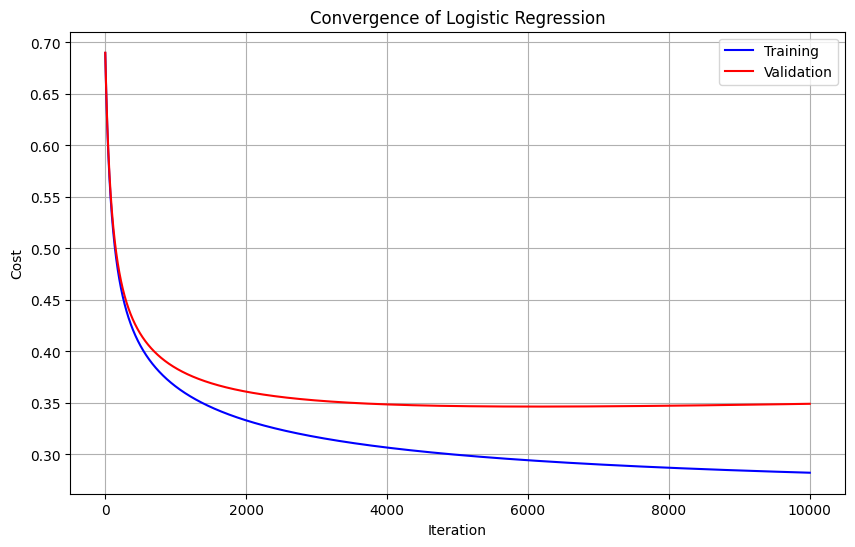

In [ ]:
# Plot convergence of training and validation data
plt.figure(figsize=(10, 6))
plt.plot(range(len(logistic_regression.cost_history_train)), logistic_regression.cost_history_train, label='Training', color='blue')
if X_val_split is not None and y_val_split is not None:
    plt.plot(range(len(logistic_regression.cost_history_val)), logistic_regression.cost_history_val, label='Validation', color='red')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Convergence of Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

## Top 10 +/- Features from Logistic Regression

Here we see the top 10 features contributing to both positive and negative sentiment from our Logistic Regression.  We see a much more logical correlation between words associated with a positive/negative distinction than was seen with the simple linear regression implementation.

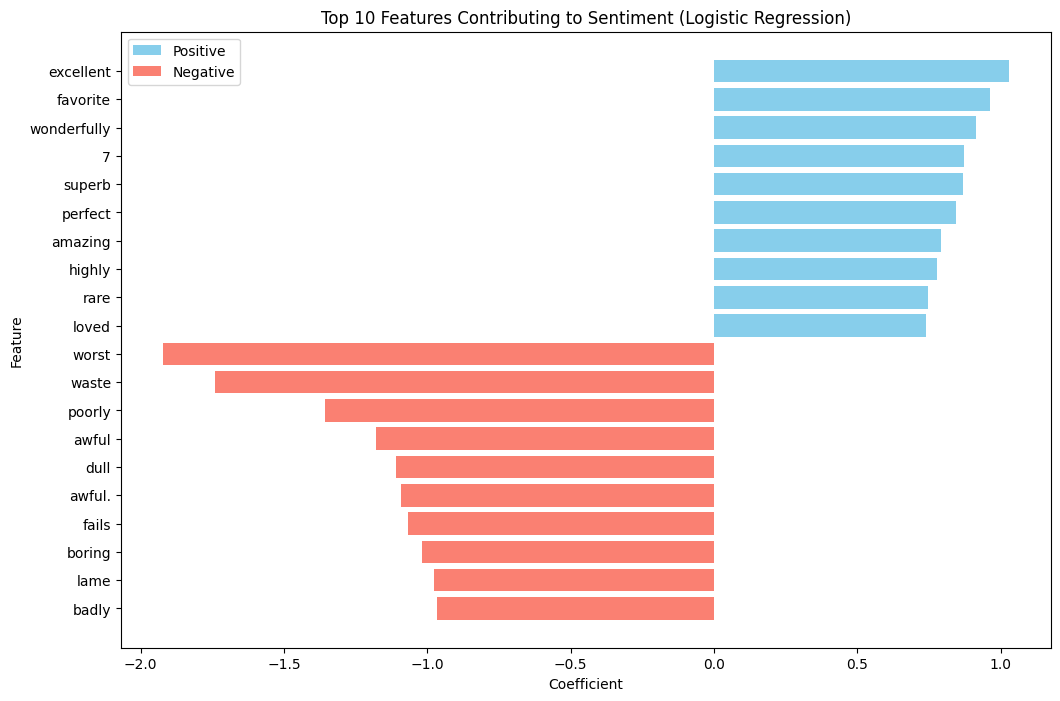

('excellent', 'favorite', 'wonderfully', '7', 'superb', 'perfect', 'amazing', 'highly', 'rare', 'loved')
(1.0271664477901652, 0.9616220483467965, 0.9125637572881781, 0.8733444879391511, 0.8682849728703693, 0.845304863947304, 0.7902154380366126, 0.7760788093888727, 0.7455531769730436, 0.7392080478277737)
('worst', 'waste', 'poorly', 'awful', 'dull', 'awful.', 'fails', 'boring', 'lame', 'badly')
(-1.921883624575095, -1.740160633924712, -1.3568880474743863, -1.1789621577242535, -1.109172507766721, -1.0934833178474992, -1.0664330824307509, -1.0190557483285276, -0.9763050921542816, -0.9652634891564819)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to sort top features by coefficients for logistic regression
def sort_top_features_by_coefficients_logistic(feature_names, coefficients, D):
    # Get indices of top D features based on coefficients
    sorted_indices = np.argsort(coefficients)

    # Extract top D features and their corresponding coefficients
    top_features_with_coefficients = [(feature_names[i], coefficients[i]) for i in sorted_indices]

    # Separate positive and negative coefficients
    positive_features = [(feature, coef) for feature, coef in top_features_with_coefficients[-D:] if coef > 0]
    negative_features = [(feature, coef) for feature, coef in top_features_with_coefficients[:D] if coef < 0]

    # Sort the top positive and negative features by coefficient values
    sorted_top_positive_features = sorted(positive_features, key=lambda x: x[1], reverse=True)
    sorted_top_negative_features = sorted(negative_features, key=lambda x: x[1])

    # Convert to lists for plotting
    top_positive_features, top_positive_coefficients = zip(*sorted_top_positive_features)
    top_negative_features, top_negative_coefficients = zip(*sorted_top_negative_features)

    return top_positive_features, top_positive_coefficients, top_negative_features, top_negative_coefficients

# Choose D = 10 for top positive and negative features
D = 10

# Get coefficients from logistic regression model
coefficients_logistic = logistic_regression.w[:-1]  # Exclude bias term

# Call the function to sort the top D features by coefficients for logistic regression
top_positive_features, top_positive_coefficients, top_negative_features, top_negative_coefficients = sort_top_features_by_coefficients_logistic(filtered_words, coefficients_logistic, D)

# Plot the top positive and negative features on the same plot
plt.figure(figsize=(12, 8))

# Plot positive features
plt.barh(top_positive_features[-10:], top_positive_coefficients[-10:], color='skyblue', label='Positive')

# Plot negative features
plt.barh(top_negative_features[:10], top_negative_coefficients[:10], color='salmon', label='Negative')

plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title("Top 10 Features Contributing to Sentiment (Logistic Regression)")
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient on top
plt.show()

print(top_positive_features)
print(top_positive_coefficients)

print(top_negative_features)
print(top_negative_coefficients)


## Task 2.1: Small Pertubation Test

Here we check our gradient descent with a small pertubation test.  We can see the results of the relative error are in line with what we would expect (a very small number, in this case 4.752217356242678e-14) where the norm of gradienct descent at the final iteration was 4.159e-03.

In [ ]:
# Initialize small perturbation test
w = np.random.randn(1)
w0 = w
epsilon = np.random.randn(1)[0] * 1e-5
w1 = w0 + epsilon
w2 = w0 - epsilon

# Compute activations
a1 = w1 * X_train
a2 = w2 * X_train

# Reshape y_train to match the shape of a1
y_train_reshaped = np.tile(y_train[:, np.newaxis], (1, X_train.shape[1]))

# Compute cross-entropy loss
ce1 = np.sum(y_train_reshaped * np.log1p(np.exp(-a1)) + (1 - y_train_reshaped) * np.log1p(np.exp(a1)))
ce2 = np.sum(y_train_reshaped * np.log1p(np.exp(-a2)) + (1 - y_train_reshaped) * np.log1p(np.exp(a2)))

# Approximated gradient
dw_num = (ce1 - ce2) / (2 * epsilon)

# Compute predictions
yh = 1 / (1 + np.exp(-X_train * w))
dw_cal = np.sum((yh - y_train_reshaped) * X_train)  # Analytical gradient

# Print results
print("Analytical Gradient:", dw_cal)
print("Approximated Gradient:", dw_num)
print("Relative Error:", ((dw_cal - dw_num) ** 2) / ((dw_cal + dw_num) ** 2))


Analytical Gradient: 635274.3971889779
Approximated Gradient: 635274.2807459347
Relative Error: 8.39932676101525e-15


# Task 3

## Method comparison using ROC curve

Below we plot the area under receiver operator characteristics curve (AUROC) for our Logistic Regression model and compare it to three models from the sklearn toolkit: KNN, Decision Tree, and Logistic Regression.  With no adjustment to the sklearn hyperparameters, our model is notably the highest achiever, significantly outperforming the sklearn KNN and Decision Tree models, and marginally outperforming the sklearn Logistic Regression model.

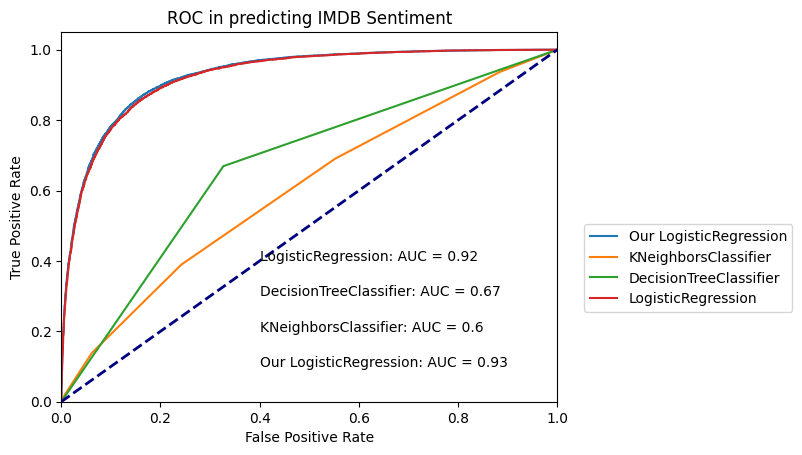

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression

models = [KNeighborsClassifier(),
          DecisionTreeClassifier(),
          sk_LogisticRegression()]

perf = {}

# Our Logistic Regression Implementation
fpr, tpr, _ = roc_curve(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)
perf["Our LogisticRegression"] = {'fpr': fpr, 'tpr': tpr, 'auroc': auroc}

# SKLearn Models
for model in models:
    fit = model.fit(X_train, y_train)
    y_test_prob = fit.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auroc = roc_auc_score(y_test, y_test_prob)
    perf[type(model).__name__] = {'fpr': fpr, 'tpr': tpr, 'auroc': auroc}

plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'], label=model_name)
    plt.text(0.4, i + 0.1, model_name + ': AUC = ' + str(round(model_perf['auroc'], 2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting IMDB Sentiment')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
# plt.show()
# plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)
# plt.close()


## Task 3.5: Comparing accuracy of model as a function of dataset training size.  

Here we compare area under the receiver operator characteristic curve (AUROC) between our Logistic Regression model and the sklearn Decision Tree.  We test with random selections of 20%, 40%, 60%, 80%, and 100% of the original training set size to see how this affects results.  The maximum iterations for Logistic Regression is set to 1000 for practical computation purposes.  We can see a slight but notable increase in accuracy as we increase or training data size, which is congruent with intuition that more training data allows a model to make more accurate predictions.


Streaming output truncated to the last 5000 lines.
Iteration 23, Norm of Gradient: 0.15043710722700357, Cost (Train): 0.6276166973492121
Iteration 24, Norm of Gradient: 0.1492928598637097, Cost (Train): 0.6253962980254026
Iteration 25, Norm of Gradient: 0.14816407489481762, Cost (Train): 0.6232092981868472
Iteration 26, Norm of Gradient: 0.14705056543231812, Cost (Train): 0.6210549977232844
Iteration 27, Norm of Gradient: 0.14595214204818874, Cost (Train): 0.6189327121993405
Iteration 28, Norm of Gradient: 0.144868613166594, Cost (Train): 0.6168417726106492
Iteration 29, Norm of Gradient: 0.14379978544670818, Cost (Train): 0.6147815251325824
Iteration 30, Norm of Gradient: 0.1427454641493967, Cost (Train): 0.612751330862573
Iteration 31, Norm of Gradient: 0.14170545348440927, Cost (Train): 0.6107505655570429
Iteration 32, Norm of Gradient: 0.14067955693665612, Cost (Train): 0.6087786193639264
Iteration 33, Norm of Gradient: 0.13966757757120898, Cost (Train): 0.606834896551736
Iteration

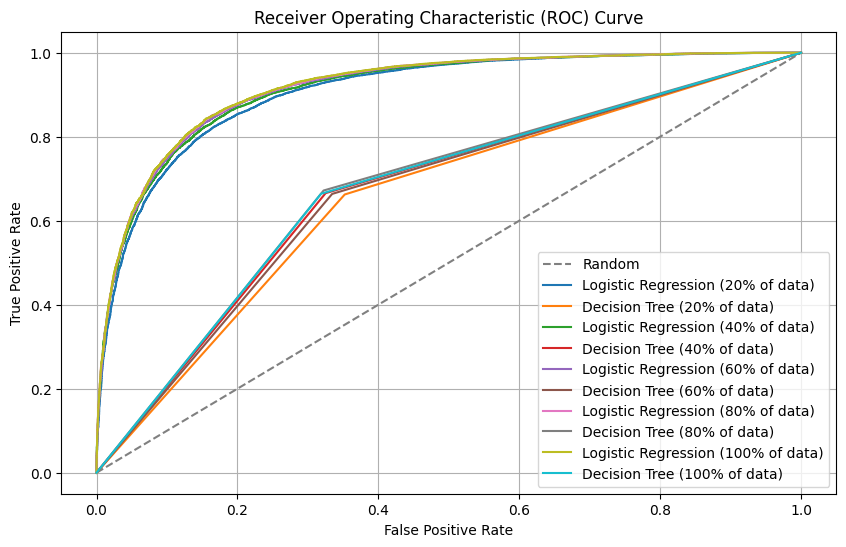

AUROC for Logistic Regression:
20% of data: 0.90729184
40% of data: 0.9135669632000001
60% of data: 0.9164716224
80% of data: 0.9179134528
100% of data: 0.9185314816000001

AUROC for Decision Tree:
20% of data: 0.65508
40% of data: 0.6702400000000001
60% of data: 0.6646799999999999
80% of data: 0.6748000000000001
100% of data: 0.67276


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score

# Define different training set sizes
training_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]

# Initialize logistic regression model
logistic_regression = LogisticRegression(add_bias=True, learning_rate=0.1, epsilon=1e-4, max_iters=1000, verbose=True)

# Initialize decision tree classifier
dt_classifier = DecisionTreeClassifier()

# Lists to store AUROC values for each training size subset
auroc_logistic_subset = []
auroc_dt_subset = []

# Lists to store ROC curve data for plotting
roc_data_logistic = []
roc_data_dt = []

# Loop through different training set sizes
for size in training_sizes:
    # Calculate the number of samples for the current size
    num_samples = int(len(X_train) * size)

    # Randomly select a portion of X_train with the current size
    random_indices = np.random.choice(len(X_train), num_samples, replace=False)
    X_train_subset = X_train[random_indices]
    y_train_subset = y_train[random_indices]

    # Fit the logistic regression model on the subset of training data
    logistic_regression.fit(X_train_subset, y_train_subset)

    # Fit the decision tree model on the same subset of training data
    dt_classifier.fit(X_train_subset, y_train_subset)

    # Make predictions on the fixed test data for logistic regression
    y_pred_logistic = logistic_regression.predict(X_test)

    # Make predictions on the fixed test data for decision tree
    y_pred_dt = dt_classifier.predict_proba(X_test)

    # Compute ROC curve for logistic regression
    fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_logistic)

    # Compute ROC curve for decision tree
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt[:, 1])

    # Compute AUROC for logistic regression and decision tree using ROC curves
    auroc_logistic_subset.append(roc_auc_score(y_test, y_pred_logistic))
    auroc_dt_subset.append(roc_auc_score(y_test, y_pred_dt[:, 1]))

    # Store ROC curve data for plotting
    roc_data_logistic.append((fpr_logistic, tpr_logistic))
    roc_data_dt.append((fpr_dt, tpr_dt))

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
for i, size in enumerate(training_sizes):
    plt.plot(roc_data_logistic[i][0], roc_data_logistic[i][1], label=f'Logistic Regression ({size*100:.0f}% of data)')
    plt.plot(roc_data_dt[i][0], roc_data_dt[i][1], label=f'Decision Tree ({size*100:.0f}% of data)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

# Print AUROC values
print("AUROC for Logistic Regression:")
for i, size in enumerate(training_sizes):
    print(f"{size*100:.0f}% of data: {auroc_logistic_subset[i]}")

print("\nAUROC for Decision Tree:")
for i, size in enumerate(training_sizes):
    print(f"{size*100:.0f}% of data: {auroc_dt_subset[i]}")


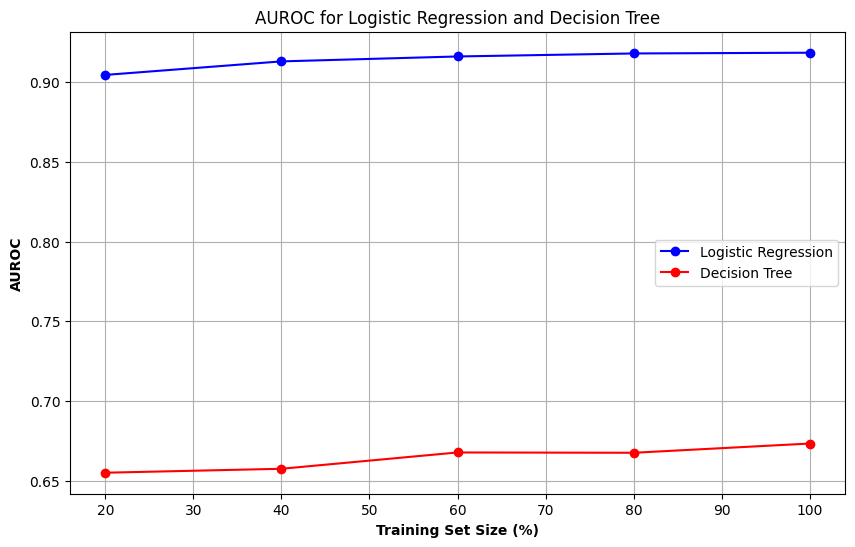

In [ ]:
import matplotlib.pyplot as plt

# AUROC values
auroc_logistic = [0.904596736, 0.9130913920000001, 0.916180576, 0.9180692224000001, 0.9185314816000001]
auroc_dt = [0.65492, 0.6574000000000001, 0.6676399999999999, 0.6674399999999999, 0.6732400000000001]

# Training set sizes
training_sizes = [20, 40, 60, 80, 100]

# Plotting
plt.figure(figsize=(10, 6))

# Plotting lines for logistic regression and decision tree
plt.plot(training_sizes, auroc_logistic, marker='o', color='b', label='Logistic Regression')
plt.plot(training_sizes, auroc_dt, marker='o', color='r', label='Decision Tree')

# Adding labels and title
plt.xlabel('Training Set Size (%)', fontweight='bold')
plt.ylabel('AUROC', fontweight='bold')
plt.title('AUROC for Logistic Regression and Decision Tree')

# Adding legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()


# Multilinear Regression on 20 News Dataset

In [5]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import random
random.seed(1234)

# Define 5 categories we want to use (randomly selected)
categories = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball', 'sci.med', 'talk.politics.guns']

# Fetch the data for the selected categories
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=False, random_state=42)

# Tokenize the text data and count word occurrences
count_vect = CountVectorizer(lowercase=True, stop_words='english', max_df=0.5, min_df=0.01)
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_test_counts = count_vect.transform(twenty_test.data)

# Calculate TF-IDF features
tfidf_transformer = TfidfTransformer(use_idf=True)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

## Mutual Information Calculation to Select Top Features

In [6]:
# Calculate Mutual Information for feature selection
mutual_info = mutual_info_classif(X_train_tfidf.toarray(), twenty_train.target)

In [7]:
# Function to get top M feature words for each class
def top_feature_words_per_class(mutual_info, features, labels, top_m=10):

    top_words_per_class = {}

    for i, label in enumerate(np.unique(labels)):
        # Get indices of features with highest mutual information for this class
        top_indices = np.argsort(mutual_info)[::-1][:top_m]
        # Get corresponding words
        top_words = [features[i] for i in top_indices]
        top_words_per_class[label] = top_words
    return top_words_per_class

# Get feature names from CountVectorizer
feature_names = np.array(count_vect.get_feature_names_out())

# Get top feature words per class
top_words_per_class = top_feature_words_per_class(mutual_info, feature_names, twenty_train.target, top_m=100)

# Take the union of top feature words across classes
top_feature_words = set()
for words in top_words_per_class.values():
    top_feature_words.update(words)

# Get indices of selected features
selected_feature_indices = [np.where(feature_names == word)[0][0] for word in top_feature_words]

# Filter the training and test data to include only selected features
X_train_selected = X_train_tfidf[:, selected_feature_indices]
X_test_selected = X_test_tfidf[:, selected_feature_indices]


X_train_selected = X_train_selected.toarray()
X_test_selected = X_test_selected.toarray()
# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_selected, twenty_train.target, test_size=0.2, random_state=42)

X_test = X_test_selected
y_test = twenty_test.target

In [8]:
# Use LabelBinarizer to one-hot encode the target variables
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_val = label_binarizer.transform(y_val)
y_test = label_binarizer.transform(y_test)

print("\nX_train shape:", X_train.shape, type(X_train))
print("y_train shape:", y_train.shape, type(y_train))
print("X_val shape:", X_val.shape, type(X_val))
print("\ny_val shape:", y_val.shape, type(y_val))
print("X_test shape:", X_test.shape, type(X_test))
print("y_test shape:", y_test.shape, type(y_test))


X_train shape: (2324, 100) <class 'numpy.ndarray'>
y_train shape: (2324, 5) <class 'numpy.ndarray'>
X_val shape: (582, 100) <class 'numpy.ndarray'>

y_val shape: (582, 5) <class 'numpy.ndarray'>
X_test shape: (1936, 100) <class 'numpy.ndarray'>
y_test shape: (1936, 5) <class 'numpy.ndarray'>


In [9]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        scores = np.dot(X, self.W)
        y_pred = np.exp(scores)
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        # Calculate the predicted probabilities
        y_pred = self.predict(X)
        # Calculate the cross-entropy loss
        crossentropy = -np.sum (y * np.log (y_pred)) # sum of all individual losses for each data point
        return crossentropy

    # Modify fit to add stopping criteria
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100, tol=1e-4):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        prev_loss_valid = float('inf')
        stopping_point = 0
        for i in range(niter):
            loss_train = self.ce(X, y)/X.shape[0]
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)/X_valid.shape[0]
                losses_valid[i] = loss_valid
                # printing removed to avoid long logging
                # print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
                # Check for convergence based on validation loss
                if abs(loss_valid - prev_loss_valid) < tol:
                    print("Convergence reached. Stopping training.")
                    stopping_point = i
                    break
                if loss_valid < prev_loss_valid: # selecting only the best validation loss
                  prev_loss_valid = loss_valid
                  print('Best validation loss: {}'.format(prev_loss_valid))
            else:
                # print(f"iter {i}: {loss_train:.3f}")
                pass
            self.W = self.W - lr * self.grad(X, y)
        return losses_train, losses_valid, stopping_point

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        return diff.sum()


In [10]:
D = X_train.shape[1] # number of features
C = y_train.shape[1] # number of classes
mlr = Multinomial_logistic(D, C)

In [11]:
# Check the gradient
gradient_diff = mlr.check_grad(X_train, y_train)
print('Checking Gradient Diff: {}'.format(gradient_diff))

Checking Gradient Diff: 1.4222267162669176e-13


Best validation loss: 1.617428365830718
Best validation loss: 1.593572555629945
Best validation loss: 1.5704206755991392
Best validation loss: 1.5479789221026936
Best validation loss: 1.5262474105573216
Best validation loss: 1.5052204621299705
Best validation loss: 1.4848872405012747
Best validation loss: 1.4652326241057083
Best validation loss: 1.446238183190232
Best validation loss: 1.427883144534151
Best validation loss: 1.4101452588695078
Best validation loss: 1.3930015237305708
Best validation loss: 1.3764287474401409
Best validation loss: 1.360403963144656
Best validation loss: 1.3449047146745858
Best validation loss: 1.3299092405905926
Best validation loss: 1.3153965819682079
Best validation loss: 1.3013466358684922
Best validation loss: 1.2877401718901156
Best validation loss: 1.2745588247942108
Best validation loss: 1.2617850724537227
Best validation loss: 1.2494022054526266
Best validation loss: 1.2373942924994936
Best validation loss: 1.225746144294081
Best validation loss: 

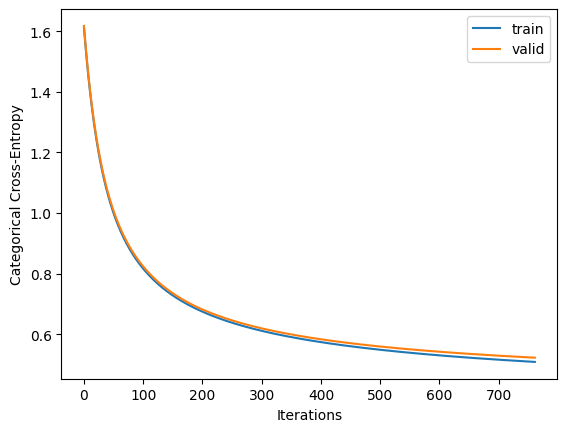

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
ce_train, ce_valid, stopping_point = mlr.fit(X_train, y_train, X_val, y_val, niter=5000)
print('Stopping Iteration at step {} after the training converged'.format(stopping_point))

plt.clf()
plt.plot(ce_train[:stopping_point], label='train')
plt.plot(ce_valid[:stopping_point], label='valid')
plt.xlabel("Iterations")
plt.ylabel("Categorical Cross-Entropy")
plt.legend()
plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

y_pred_test = mlr.predict(X_test)
predicted_classes = np.argmax(y_pred_test, axis=1)
actual_classes_test = np.argmax(y_test, axis=1)
actual_classes_train = np.argmax(y_train, axis=1)
print('MLR Accuracy: {}'.format(accuracy_score(actual_classes_test, predicted_classes)))

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, actual_classes_train)
dt_pred = clf.predict(X_test)
print('DT Accuracy: {}'.format(accuracy_score(actual_classes_test, dt_pred)))

MLR Accuracy: 0.7954545454545454
DT Accuracy: 0.7386363636363636


Accuracy as a function of the training size

In [14]:
train_acc_dict_mlr = {}
train_acc_dict_dt = {}

for train_size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
  X_train, X_val, y_train, y_val = train_test_split(X_train_selected, twenty_train.target, test_size=1-train_size, random_state=42)
  # print(X_train.shape)
  # print(y_train.shape)

  label_binarizer = LabelBinarizer()
  y_train = label_binarizer.fit_transform(y_train)
  y_val = label_binarizer.transform(y_val)

  D = X_train.shape[1] # number of features
  C = y_train.shape[1] # number of classes
  mlr = Multinomial_logistic(D, C)
  _, _, _ = mlr.fit(X_train, y_train, X_val, y_val, niter=5000)

  y_pred_test = mlr.predict(X_test)
  predicted_classes = np.argmax(y_pred_test, axis=1)
  acc = accuracy_score(actual_classes_test, predicted_classes)

  train_acc_dict_mlr[train_size] = acc

  actual_classes_train = np.argmax(y_train, axis=1)
  clf = DecisionTreeClassifier(random_state=42)
  clf.fit(X_train, actual_classes_train)
  dt_pred = clf.predict(X_test)
  dt_accuracy = accuracy_score(actual_classes_test, dt_pred)

  train_acc_dict_dt[train_size] = dt_accuracy

Streaming output truncated to the last 5000 lines.
Best validation loss: 0.5885703365890169
Best validation loss: 0.5883943476677113
Best validation loss: 0.5882187659400714
Best validation loss: 0.5880435899455911
Best validation loss: 0.5878688182308774
Best validation loss: 0.5876944493496074
Best validation loss: 0.5875204818624846
Best validation loss: 0.5873469143371967
Best validation loss: 0.5871737453483716
Best validation loss: 0.5870009734775371
Best validation loss: 0.5868285973130765
Best validation loss: 0.5866566154501891
Best validation loss: 0.5864850264908474
Best validation loss: 0.5863138290437567
Best validation loss: 0.5861430217243142
Best validation loss: 0.585972603154568
Best validation loss: 0.5858025719631778
Best validation loss: 0.5856329267853743
Best validation loss: 0.5854636662629197
Best validation loss: 0.5852947890440687
Best validation loss: 0.5851262937835294
Best validation loss: 0.5849581791424239
Best validation loss: 0.5847904437882508
Best va

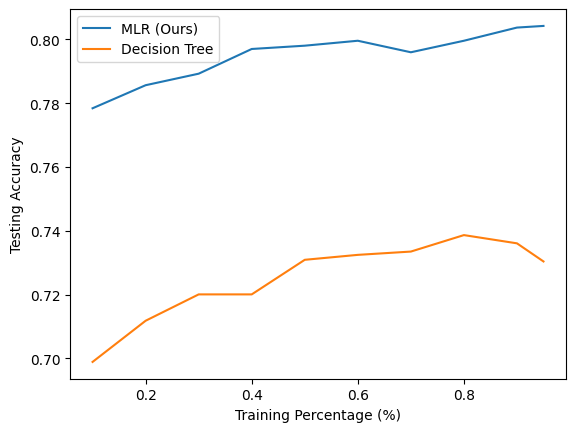

<Figure size 640x480 with 0 Axes>

In [15]:
training_percentages = np.array(list(train_acc_dict_mlr.keys()))
mlr_testing_accuracies = np.array(list(train_acc_dict_mlr.values()))
dt_testing_accuracies = np.array(list(train_acc_dict_dt.values()))

plt.clf()
plt.plot(training_percentages, mlr_testing_accuracies, label='MLR (Ours)')
plt.plot(training_percentages, dt_testing_accuracies, label='Decision Tree')
plt.xlabel("Training Percentage (%)")
plt.ylabel("Testing Accuracy")
plt.legend()
plt.show()
plt.savefig("accuracy_function_of_training_size.png", bbox_inches="tight", dpi=300)

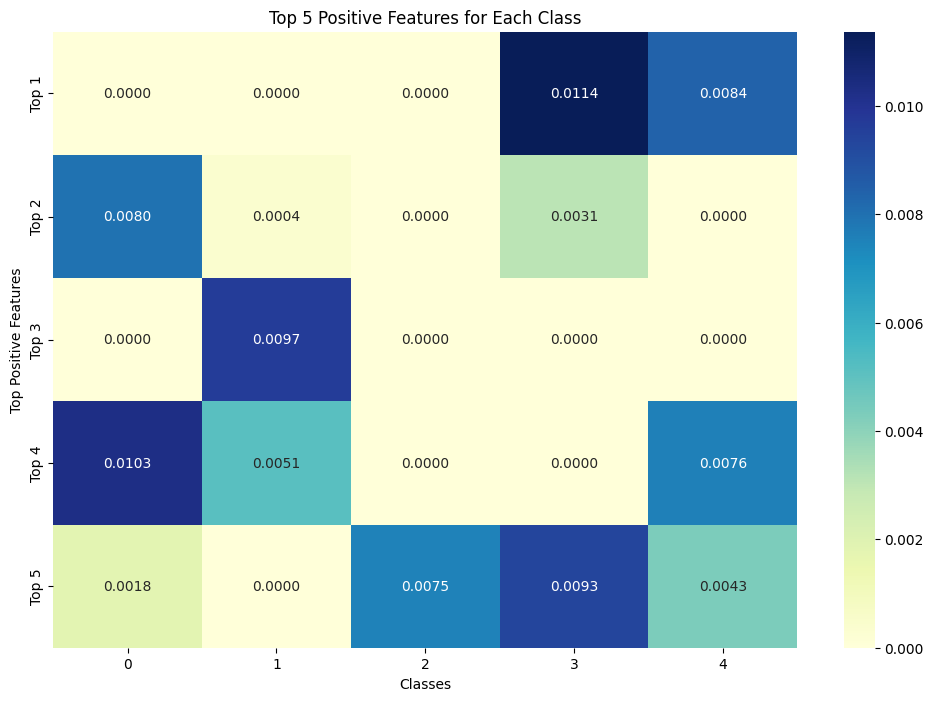

In [16]:

# Generate heatmap
import seaborn as sns

# Function to extract the top N positive features for each class
def top_positive_features_per_class(weights, features, labels, top_n=5):
    top_features_per_class = {}
    for i, label in enumerate(np.unique(labels)):
        # Get indices of top positive features for this class
        top_indices = np.argsort(weights[:, i])[::-1][:top_n]
        # Get corresponding words
        top_words = [features[idx] for idx in top_indices]
        top_features_per_class[label] = top_words
    return top_features_per_class

# Get top positive features per class
top_positive_features = top_positive_features_per_class(mlr.W, feature_names, twenty_train.target, top_n=5)

# Prepare data for heatmap
heatmap_data = np.zeros((len(top_positive_features.keys()), len(top_positive_features[0])))
for i, label in enumerate(sorted(top_positive_features.keys())):
    heatmap_data[i, :] = [mutual_info_classif(X_train_tfidf.toarray(), twenty_train.target == label)[count_vect.vocabulary_[word]] for word in top_positive_features[label]]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="YlGnBu", xticklabels=sorted(top_positive_features.keys()), yticklabels=["Top {}".format(i+1) for i in range(5)])
plt.xlabel("Classes")
plt.ylabel("Top Positive Features")
plt.title("Top 5 Positive Features for Each Class")
plt.show()
